# **Step 1: Load training and testing datasets**

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, f1_score
)

In [2]:
train_data = pd.read_csv("/kaggle/input/credit-default-prediction-ai-big-data/train.csv")
test_data = pd.read_csv("/kaggle/input/credit-default-prediction-ai-big-data/test.csv")

# **Step 2: Display dataset information**

In [3]:
def quality_report(df, name):
    print(f"\n{name} Data Information:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nSummary Statistics:")
    print(df.describe())

quality_report(train_data, "Train")
quality_report(test_data, "Test")


Train Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 no

# **Step 3: Handle missing values**

In [4]:
train_numerical_features = train_data.select_dtypes(include=[np.number]).columns
train_categorical_features = train_data.select_dtypes(exclude=[np.number]).columns

test_numerical_features = test_data.select_dtypes(include=[np.number]).columns
test_categorical_features = test_data.select_dtypes(exclude=[np.number]).columns

# Impute numerical values
imputer_num_train = SimpleImputer(strategy='mean')
train_data[train_numerical_features] = imputer_num_train.fit_transform(train_data[train_numerical_features])

imputer_num_test = SimpleImputer(strategy='mean')
test_data[test_numerical_features] = imputer_num_test.fit_transform(test_data[test_numerical_features])

# Impute categorical values
imputer_cat_train = SimpleImputer(strategy='most_frequent')
train_data[train_categorical_features] = imputer_cat_train.fit_transform(train_data[train_categorical_features])

imputer_cat_test = SimpleImputer(strategy='most_frequent')
test_data[test_categorical_features] = imputer_cat_test.fit_transform(test_data[test_categorical_features])

# **Step 4: Preprocess Data**

In [5]:
# Ensure the categorical columns match
common_categorical_features = list(set(train_categorical_features) & set(test_categorical_features))

# Encode categorical variables using OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)  # Use sparse_output instead of sparse

# Fit encoder on training set and transform both train and test sets
categorical_encoded_train = encoder.fit_transform(train_data[common_categorical_features])
categorical_encoded_test = encoder.transform(test_data[common_categorical_features])

# Convert encoded categorical features to DataFrame
categorical_df_train = pd.DataFrame(categorical_encoded_train, columns=encoder.get_feature_names_out(common_categorical_features))
categorical_df_test = pd.DataFrame(categorical_encoded_test, columns=encoder.get_feature_names_out(common_categorical_features))

# Ensure indices are reset for concatenation
categorical_df_train.index = train_data.index
categorical_df_test.index = test_data.index

# Identify numerical features separately for train and test
train_numerical_features = train_data.select_dtypes(include=[np.number]).columns
test_numerical_features = test_data.select_dtypes(include=[np.number]).columns

# Ensure the numerical columns match
common_numerical_features = list(set(train_numerical_features) & set(test_numerical_features))

# Normalize numerical features
scaler = StandardScaler()
train_data[common_numerical_features] = scaler.fit_transform(train_data[common_numerical_features])
test_data[common_numerical_features] = scaler.transform(test_data[common_numerical_features])

# Concatenate processed numerical and categorical features
processed_train = pd.concat([train_data[common_numerical_features], categorical_df_train], axis=1)
processed_test = pd.concat([test_data[common_numerical_features], categorical_df_test], axis=1)

# Splitting features and target variable
X_train = processed_train.drop(columns=['Credit Default'], errors='ignore')  # 'errors=ignore' prevents KeyError if 'target' is missing
y_train = train_data['Credit Default']

# Define X_test (test set does not have a target column)
X_test = processed_test  # Use the processed test dataset

# **Step 5: Model training and evaluation**

Random Forest - Accuracy: 1.00, F1 Score: 1.00, Precision: 1.00, Recall: 1.00
SVM Linear - Accuracy: 0.77, F1 Score: 0.33, Precision: 0.98, Recall: 0.20
SVM Kernel - Accuracy: 0.77, F1 Score: 0.33, Precision: 1.00, Recall: 0.20
Logistic Regression - Accuracy: 0.78, F1 Score: 0.41, Precision: 0.83, Recall: 0.28
Decision Tree - Accuracy: 1.00, F1 Score: 1.00, Precision: 1.00, Recall: 1.00
Naïve Bayes - Accuracy: 0.72, F1 Score: 0.50, Precision: 0.50, Recall: 0.49


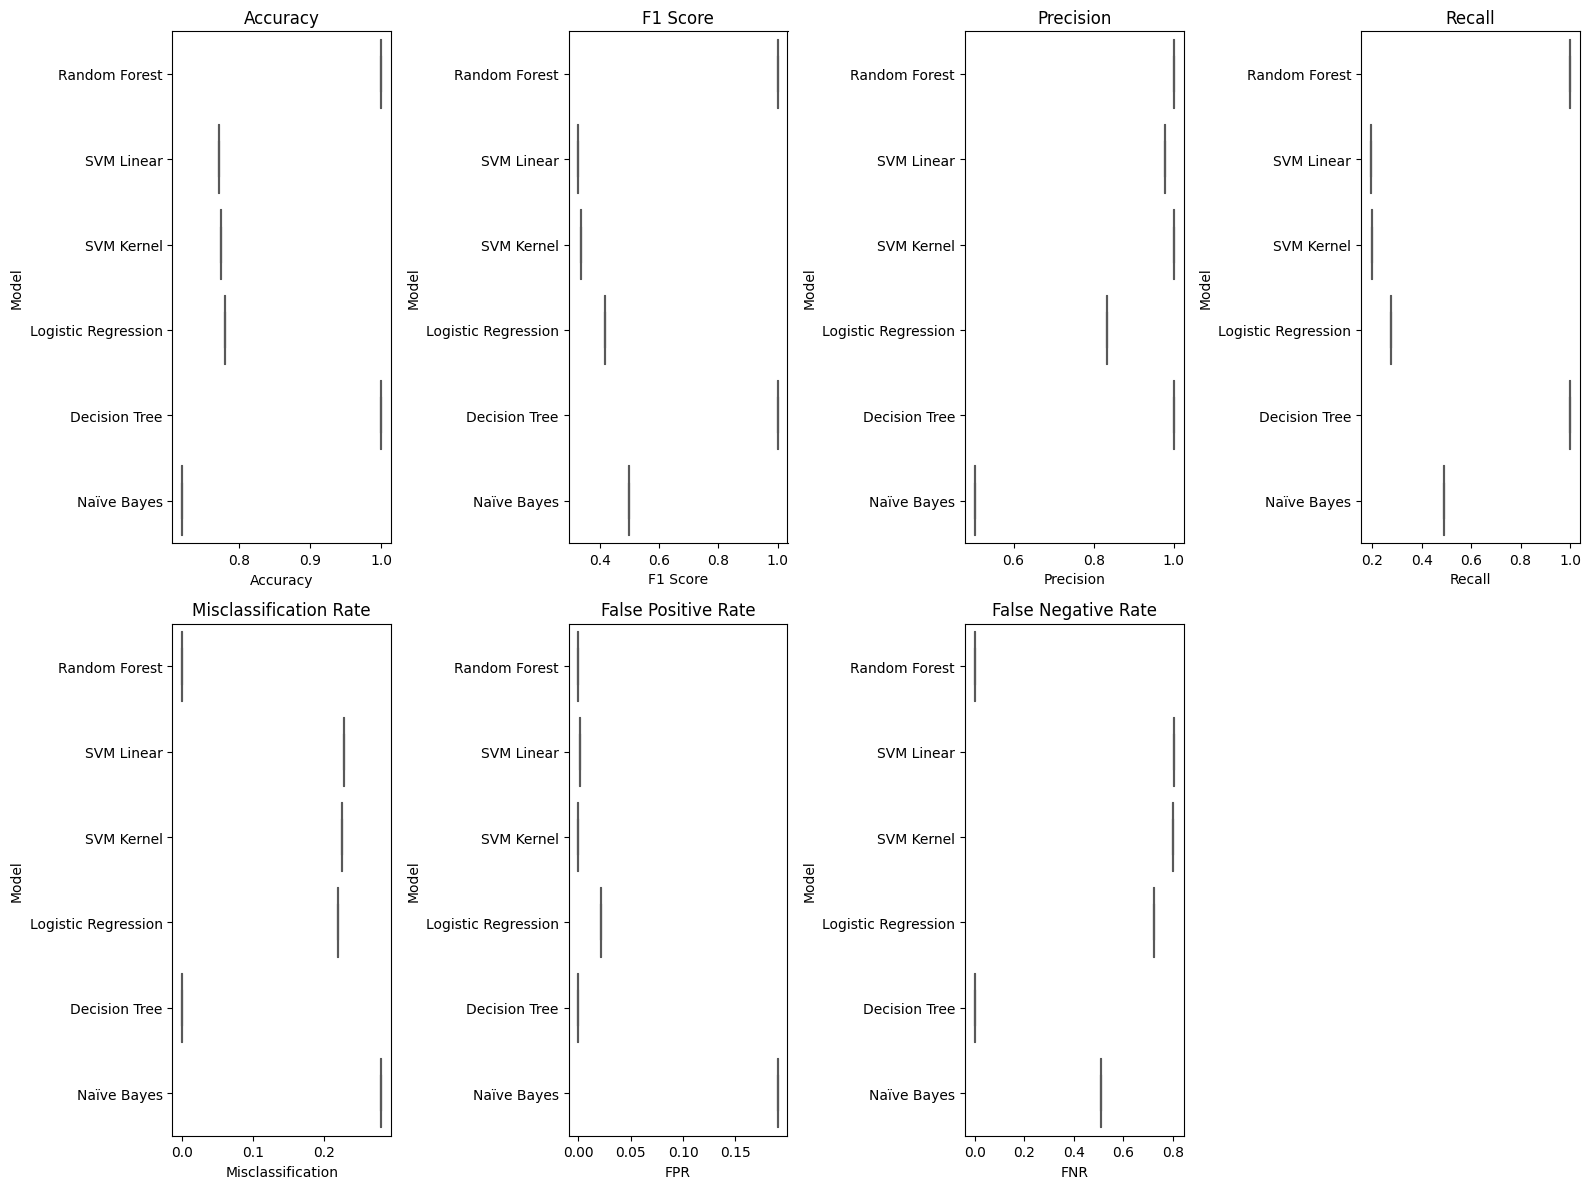

Predictions saved to 'sampleSubmission.csv'.


In [6]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM Linear": SVC(kernel="linear"),
    "SVM Kernel": SVC(kernel="rbf"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB()
}

# Initialize results table
results = []

# For simplicity, using training data to evaluate models (as y_test is unavailable)
for name, model in models.items():
    start_train = time.time()
    model.fit(X_train, y_train)  # Train model
    train_time = time.time() - start_train

    # Prediction on training data since test.csv doesn't have the target column
    start_pred = time.time()
    y_pred_train = model.predict(X_train)  # Predict on training data (since no y_test)
    pred_time = time.time() - start_pred

    # Compute metrics based on training data
    accuracy = accuracy_score(y_train, y_pred_train)
    precision = precision_score(y_train, y_pred_train, average='binary')
    recall = recall_score(y_train, y_pred_train, average='binary')
    f1 = f1_score(y_train, y_pred_train, average='binary')

    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    misclassification = (fp + fn) / len(y_train)
    tnr = tn / (tn + fp)  # True Negative Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    tpr = tp / (tp + fn)  # True Positive Rate

    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Misclassification": misclassification,
        "TNR": tnr,
        "FPR": fpr,
        "FNR": fnr,
        "TPR": tpr,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Time to Train": train_time,
        "Time to Predict": pred_time
    })

    print(f"{name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV for future analysis
results_df.to_csv("model_results.csv", index=False)

# Create boxplots for model comparison
metrics = ["Accuracy", "F1 Score", "Precision", "Recall", "Misclassification", "FPR", "FNR"]
titles = ["Accuracy", "F1 Score", "Precision", "Recall", "Misclassification Rate", "False Positive Rate", "False Negative Rate"]

# Adjusting the figure size and number of rows/columns for the boxplots
plt.figure(figsize=(16, 12))  # Increase the figure size

# Create subplots for each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 4, i+1)  # Adjust to 2 rows and 4 columns for better spacing
    sns.boxplot(data=results_df, x=metric, y="Model", palette="Set2")
    plt.title(titles[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Prepare the sample submission file (for test data predictions)
submission = pd.DataFrame({
    "Id": test_data["Id"],  # Assuming "Id" exists in test.csv
    "Credit Default": models["Random Forest"].predict(X_test)  # Using Random Forest predictions
})

# Save the CSV file inside the 'results' folder
submission.to_csv("sampleSubmission.csv", index=False)
print("Predictions saved to 'sampleSubmission.csv'.")